# Data Storage

## Install libraries & packages

In [4]:
## Install libraries & install packages needed to run MongoDB
import requests
import time
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
os.environ['PATH'] += os.pathsep + '/usr/local/bin' 

## Start Docker container

In [6]:
!docker-compose up -d

 Container my_jupyter  Running
 Container bdeng-zookeeper-1  Running
 Container my_spark  Running
 Container bdeng-kafka-1  Running


### Check if the services are running

In [8]:
!docker ps

CONTAINER ID   IMAGE                              COMMAND                  CREATED       STATUS                 PORTS                                              NAMES
8287f55e16d6   confluentinc/cp-kafka:latest       "/etc/confluent/dockâ€¦"   2 hours ago   Up 2 hours             0.0.0.0:9092->9092/tcp, 0.0.0.0:29093->29093/tcp   bdeng-kafka-1
79eed9104642   confluentinc/cp-zookeeper:latest   "/etc/confluent/dockâ€¦"   2 hours ago   Up 2 hours             2888/tcp, 3888/tcp, 0.0.0.0:32181->2181/tcp        bdeng-zookeeper-1
ab08ccae6b56   jupyter/base-notebook:latest       "tini -g -- start-noâ€¦"   2 hours ago   Up 2 hours (healthy)   0.0.0.0:8888->8888/tcp                             my_jupyter
6fcce3b26080   bitnami/spark:latest               "/opt/bitnami/scriptâ€¦"   2 hours ago   Up 2 hours             0.0.0.0:7077->7077/tcp, 0.0.0.0:8080->8080/tcp     my_spark


# Process CSV Data

### Read data and display the first few rows

In [82]:
import pandas as pd

# Read the CSV file with the specified encoding
poi_df = pd.read_csv('data/top-locations-wien.csv', encoding='latin1', sep=';')


# Display the first few rows of the dataframe
print(poi_df.head())

             title    category  \
0        21er Haus      museum   
1   A.E. Kï¿½chert    shopping   
2             Aida       cafes   
3  Akademietheater  musicstage   
4        Albertina      museum   

                                        Beschreibung                  address  \
0  Das Museum wurde 2011 saniert und stellt unter...        Arsenalstraï¿½e 1   
1  Dieser Traditions-Juwelier schmï¿½ckt heute mi...          Neuer Markt 15    
2  Aida ist eine Wiener Konditoreikette. Das Desi...  Stock-im-Eisen-Platz 2    
3  Seit 1922 ist das Akademietheater die zweite S...          Lisztstraï¿½e 1   
4  Die Albertina besitzt nicht nur eine der grï¿½...        Albertinaplatz 1    

    zip  city      geo_latitude     geo_longitude             tel_1  \
0  1030  Wien  48,1857710810320  16,3836224650817  +43 1 795 57-134   
1  1010  Wien        48,2065731        16,3705892               NaN   
2  1010  Wien        48,2080194        16,3720473  +43 1 512 79 25    
3  1030  Wien        48,

In [86]:
# Create new DataFrame for the Vizualisation (category and coordinates)

# Auswahl der gewünschten Spalten
new_df = poi_df[['category', 'geo_latitude', 'geo_longitude']]
# Ausgabe des neuen DataFrames
print(new_df)

        category      geo_latitude     geo_longitude
0         museum  48,1857710810320  16,3836224650817
1       shopping        48,2065731        16,3705892
2          cafes        48,2080194        16,3720473
3     musicstage        48,2002455        16,3770872
4         museum        48,2048541        16,3681588
..           ...               ...               ...
130   gastronomy         48,204367        16,3688208
131   gastronomy         48,210862         16,372725
132  sightseeing        48,1542998         16,441214
133       museum       48,20222973       16,35943794
134     shopping        48,2090112        16,3696138

[135 rows x 3 columns]


### Check for missing values

In [54]:
print(new_df.isnull().sum())

category         0
geo_latitude     0
geo_longitude    0
dtype: int64


### CSV-Data cleaning

In [56]:
# Fill or drop missing values
new_df = new_df.dropna()  # Dropping rows with missing values

# Check for duplicates
print(new_df.duplicated().sum())

# Remove duplicates
new_df = new_df.drop_duplicates()

5


### Show clean Dataframe

In [58]:
print(new_df)

        category geo_latitude geo_longitude
0       shopping   48,2065731    16,3705892
1          cafes   48,2080194    16,3720473
2     musicstage   48,2002455    16,3770872
3         museum   48,2048541    16,3681588
4          cafes   48,2083379    16,3709213
..           ...          ...           ...
129   gastronomy    48,204367    16,3688208
130   gastronomy    48,210862     16,372725
131  sightseeing   48,1542998     16,441214
132       museum  48,20222973   16,35943794
133     shopping   48,2090112    16,3696138

[129 rows x 3 columns]


## Save data locally

In [60]:
# Speichern des DataFrames als CSV-Datei mit richtiger Spaltenstruktur
new_df.to_csv('data/poi_coordinates.csv', index=False, sep=';')

print("Datei wurde erfolgreich im 'data'-Ordner gespeichert.")

Datei wurde erfolgreich im 'data'-Ordner gespeichert.


## Analyse and Vizualisation of CSV-Data

In [22]:
!pip install pandas matplotlib seaborn folium geopandas shapely


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


       geo_latitude  geo_longitude
count    127.000000     127.000000
mean      48.204349      16.363902
std        0.011157       0.022701
min       48.154300      16.246082
25%       48.200776      16.358912
50%       48.205188      16.368290
75%       48.209458      16.373269
max       48.240283      16.441214
category
shopping          29
museum            23
musicstage        18
sightseeing       15
cafes             14
nightlife         12
gastronomy        11
restaurants        4
accommodations     1
Name: count, dtype: int64


C:\Users\ayseo\AppData\Local\Temp\ipykernel_4192\2853225410.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='category', palette='viridis')


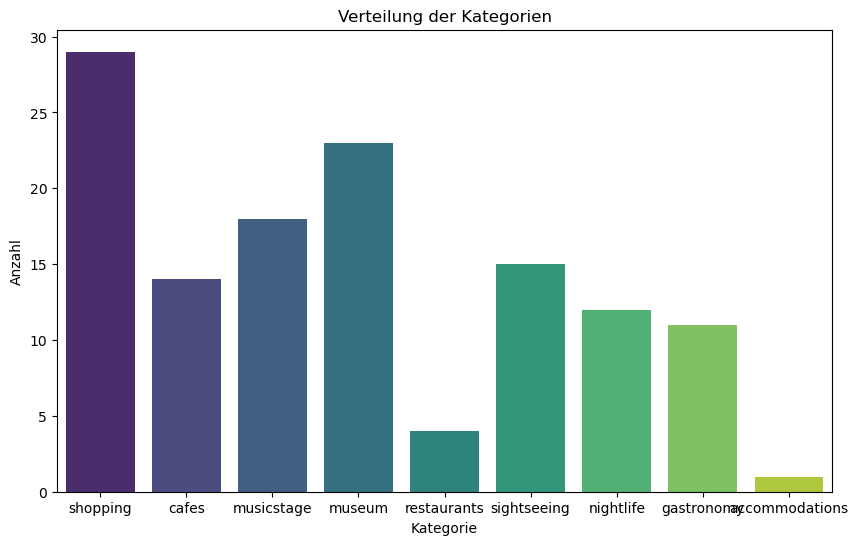

Die Karte wurde erfolgreich als 'poi_map_vienna.html' gespeichert.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point

# Gegebene Daten für Kategorien und Koordinaten
data = pd.read_csv('data/poi_coordinates.csv', encoding='latin1', sep=';')

# DataFrame erstellen
new_df = pd.DataFrame(data)

# Filtern nach den gewünschten Kategorien
desired_categories = ['museum', 'shopping', 'cafes', 'musicstage', 
                      'restaurants', 'sightseeing', 'nightlife', 
                      'gastronomy', 'accommodations']
new_df['category'] = new_df['category'].str.lower()  # Konvertierung zu Kleinbuchstaben für die Kategorienvergleich
new_df = new_df[new_df['category'].isin(desired_categories)]

# Konvertierung der Koordinaten von Strings zu Floats
new_df['geo_latitude'] = new_df['geo_latitude'].str.replace(',', '.').astype(float)
new_df['geo_longitude'] = new_df['geo_longitude'].str.replace(',', '.').astype(float)

# Grundlegende Analyse
print(new_df.describe())
print(new_df['category'].value_counts())

# Visualisierung der Verteilung der Kategorien mit Matplotlib und Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=new_df, x='category', palette='viridis')
plt.title('Verteilung der Kategorien')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl')
plt.show()

# Erstellen einer Karte für Wien mit Folium
map_vienna = folium.Map(location=[48.210033, 16.363449], zoom_start=13)

# MarkerCluster für eine bessere Darstellung von dichten Markergruppen
marker_cluster = MarkerCluster().add_to(map_vienna)

# Funktion zur Zuordnung von Farben basierend auf der Kategorie
def get_color(category):
    if category == 'museum':
        return 'purple'
    elif category == 'shopping':
        return 'blue'
    elif category == 'cafes':
        return 'green'
    elif category == 'musicstage':
        return 'orange'
    elif category == 'restaurants':
        return 'red'
    elif category == 'sightseeing':
        return 'darkblue'
    elif category == 'nightlife':
        return 'darkred'
    elif category == 'gastronomy':
        return 'lightgreen'
    elif category == 'accommodations':
        return 'cadetblue'
    else:
        return 'gray'  # Fallback für unbekannte Kategorien

# Hinzufügen der POI-Marker zur Karte
for _, row in new_df.iterrows():
    folium.Marker(
        location=[row['geo_latitude'], row['geo_longitude']],
        popup=row['category'].capitalize(),
        icon=folium.Icon(color=get_color(row['category']))
    ).add_to(marker_cluster)

# Speichern der Karte als HTML-Datei
map_vienna.save('data/poi_map_vienna1.html')

# Ausgabe, um den Benutzer darüber zu informieren, dass die Karte gespeichert wurde
print("Die Karte wurde erfolgreich als 'poi_map_vienna.html' gespeichert.")


# Kafka Producer & Consumer

In [12]:
# Load important libraries
from kafka import KafkaProducer
import requests
import json
import time
# Create Kafka producer
producer = KafkaProducer(bootstrap_servers=['localhost:29093'],
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))


In [14]:
import pandas as pd

# Gegebene Daten für Kategorien und Koordinaten
data = pd.read_csv('data/poi_coordinates.csv', encoding='latin1', sep=';')

# DataFrame erstellen
new_df = pd.DataFrame(data)

# Filtern nach den gewünschten Kategorien
desired_categories = ['museum', 'shopping', 'cafes', 'musicstage', 
                      'restaurants', 'sightseeing', 'nightlife', 
                      'gastronomy', 'accommodations']
new_df['category'] = new_df['category'].str.lower()  # Konvertierung zu Kleinbuchstaben für die Kategorienvergleich
new_df = new_df[new_df['category'].isin(desired_categories)]

# Bereinigung der Koordinaten
new_df['geo_latitude'] = new_df['geo_latitude'].str.replace(',', '.')
new_df['geo_longitude'] = new_df['geo_longitude'].str.replace(',', '.')

# Entfernen von Zeilen mit ungültigen Koordinaten
new_df = new_df[new_df['geo_latitude'].apply(lambda x: x.replace('.', '', 1).isdigit())]
new_df = new_df[new_df['geo_longitude'].apply(lambda x: x.replace('.', '', 1).isdigit())]

# Konvertieren der Koordinaten in das richtige Format
new_df['geo_latitude'] = new_df['geo_latitude'].astype(float)
new_df['geo_longitude'] = new_df['geo_longitude'].astype(float)

# Debug-Ausgabe nach der Konvertierung
print("Nach der Konvertierung:")
print(new_df[['geo_latitude', 'geo_longitude']].head())
print(new_df.dtypes)


Nach der Konvertierung:
   geo_latitude  geo_longitude
0     48.206573      16.370589
1     48.208019      16.372047
2     48.200246      16.377087
3     48.204854      16.368159
4     48.208338      16.370921
category          object
geo_latitude     float64
geo_longitude    float64
dtype: object


In [16]:
import requests
print(new_df.head())
print(new_df.dtypes)
# REST API URL
api_url = 'https://api.nextbike.net/maps/nextbike-live.json'

def fetch_data():
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as e:
        print(f"Fehler beim Abrufen der Daten: {e}")
        return None

nextbike_data = fetch_data()

# Beispielstruktur: Daten verarbeiten
wien_data = []

if nextbike_data is not None:
    for country in nextbike_data.get('countries', []):
        if country.get('country_name') == 'Austria':
            for city in country.get('cities', []):
                if city.get('name') == 'Wien':
                    for place in city.get('places', []):
                         if not place.get('name', '').startswith('BIKE'):
                            station_data = {
                                'station': place.get('name'),
                                'geo_latitude': str(place.get('lat')).replace(',', '.'),
                                'geo_longitude': str(place.get('lng')).replace(',', '.'),
                                'available_bikes': place.get('bikes')
                            }
                            wien_data.append(station_data)

# Umwandlung in ein Pandas DataFrame
wien_df = pd.DataFrame(wien_data)
wien_df['geo_latitude'] = wien_df['geo_latitude'].astype(float)
wien_df['geo_longitude'] = wien_df['geo_longitude'].astype(float)

# Entfernen der ersten Zeile
wien_df = wien_df.drop(index=0).reset_index(drop=True)

# Überprüfen der Spaltennamen und Daten
print("Wien DataFrame:")
print(wien_df.head())
print(wien_df.dtypes)


     category  geo_latitude  geo_longitude
0    shopping     48.206573      16.370589
1       cafes     48.208019      16.372047
2  musicstage     48.200246      16.377087
3      museum     48.204854      16.368159
4       cafes     48.208338      16.370921
category          object
geo_latitude     float64
geo_longitude    float64
dtype: object
Wien DataFrame:
           station  geo_latitude  geo_longitude  available_bikes
0      Hoher Markt     48.210666      16.372983               17
1             Oper     48.202683      16.369702                0
2      Volksgarten     48.206516      16.360400                2
3  Stephansplatz U     48.207836      16.372111                0
4   Taborstraße U2     48.219522      16.382218               21
station             object
geo_latitude       float64
geo_longitude      float64
available_bikes      int64
dtype: object


# Karte mit POIs und Nextbike-Stationen

In [18]:
import folium
from folium.plugins import MarkerCluster

# Erstellen einer Karte für Wien mit Folium
map_vienna = folium.Map(location=[48.210033, 16.363449], zoom_start=13)

# MarkerCluster für eine bessere Darstellung von dichten Markergruppen
poi_marker_cluster = MarkerCluster().add_to(map_vienna)
nextbike_marker_cluster = MarkerCluster().add_to(map_vienna)

# Funktion zur Zuordnung von Farben basierend auf der Kategorie
def get_color(category):
    if category == 'museum':
        return 'purple'
    elif category == 'shopping':
        return 'blue'
    elif category == 'cafes':
        return 'green'
    elif category == 'musicstage':
        return 'orange'
    elif category == 'restaurants':
        return 'red'
    elif category == 'sightseeing':
        return 'darkblue'
    elif category == 'nightlife':
        return 'darkred'
    elif category == 'gastronomy':
        return 'lightgreen'
    elif category == 'accommodations':
        return 'cadetblue'
    else:
        return 'gray'  # Fallback für unbekannte Kategorien

# POI-Marker
for _, row in new_df.iterrows():
    folium.Marker(
        location=[row['geo_latitude'], row['geo_longitude']],
        popup=row['category'].capitalize(),
        icon=folium.Icon(color=get_color(row['category']))
    ).add_to(poi_marker_cluster)

# Nextbike-Stationen
for _, row in wien_df.iterrows():
    folium.Marker(
        location=[row['geo_latitude'], row['geo_longitude']],
        popup=f"Station: {row['station']}, Available bikes: {row['available_bikes']}",
        icon=folium.Icon(color='pink', icon='bicycle', prefix='fa')  # Verwenden Sie ein anderes Symbol und eine andere Farbe
    ).add_to(nextbike_marker_cluster)

# Speichern der Karte als HTML-Datei
map_vienna.save('data/poi_map_vienna2.html')

print("Die Karte wurde erfolgreich als 'poi_map_vienna2.html' gespeichert.")

Die Karte wurde erfolgreich als 'poi_map_vienna2.html' gespeichert.


# Zuordnung bei welchen Kategorien die meisten Nextbike-Stationen sind 

In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Konvertieren der Koordinaten in floats
poi_df['geo_latitude'] = poi_df['geo_latitude'].astype(float)
poi_df['geo_longitude'] = poi_df['geo_longitude'].astype(float)

# Erstellen von GeoDataFrames
poi_gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.geo_longitude, poi_df.geo_latitude))

print("POI GeoDataFrame nach der Konvertierung:")
print(poi_gdf[['geo_latitude', 'geo_longitude', 'category']].head())
print(poi_gdf.dtypes)


POI GeoDataFrame nach der Konvertierung:
   geo_latitude  geo_longitude    category
0     48.206573      16.370589    shopping
1     48.208019      16.372047       cafes
2     48.200246      16.377087  musicstage
3     48.204854      16.368159      museum
4     48.208338      16.370921       cafes
category           object
geo_latitude      float64
geo_longitude     float64
geometry         geometry
dtype: object


In [144]:
# Konvertieren der Koordinaten in das richtige Format
wien_df['geo_latitude'] = wien_df['geo_latitude'].astype(float)
wien_df['geo_longitude'] = wien_df['geo_longitude'].astype(float)

# Erstellen von GeoDataFrames für Nextbike-Stationen
wien_gdf = gpd.GeoDataFrame(wien_df, geometry=gpd.points_from_xy(wien_df.geo_longitude, wien_df.geo_latitude))

print(wien_gdf[['geo_latitude', 'geo_longitude', 'station']].head())
print(wien_gdf.dtypes)


   geo_latitude  geo_longitude            station
0     48.211544      16.382374  Julius-Raab-Platz
1     48.210666      16.372983        Hoher Markt
2     48.202683      16.369702               Oper
3     48.206516      16.360400        Volksgarten
4     48.207836      16.372111    Stephansplatz U
station              object
geo_latitude        float64
geo_longitude       float64
available_bikes       int64
geometry           geometry
dtype: object


In [ ]:
poi_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
wien_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

buffer_radius = 1500  # 1500 Meter

# Projektion in ein metrisches System (z.B. UTM) für das Erstellen der Puffer
poi_gdf = poi_gdf.to_crs(epsg=32633)  # UTM Zone 33N für Wien
wien_gdf = wien_gdf.to_crs(epsg=32633)

# Erstellen der Puffer um die POIs
poi_gdf['buffer'] = poi_gdf.geometry.buffer(buffer_radius)

poi_gdf.set_geometry('buffer', inplace=True)

joined_gdf = gpd.sjoin(wien_gdf, poi_gdf[['category', 'buffer']], predicate='within')

# Zähle die Anzahl der Nextbike-Stationen in der Nähe jeder POI-Kategorie
category_station_counts = joined_gdf.groupby('category').size().reset_index(name='station_count')

print("Anzahl der Nextbike-Stationen in der Nähe jeder POI-Kategorie:")
print(category_station_counts)

C:\Users\ayseo\AppData\Local\Temp\ipykernel_18152\1919752655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_station_counts, x='category', y='station_count', palette='viridis')


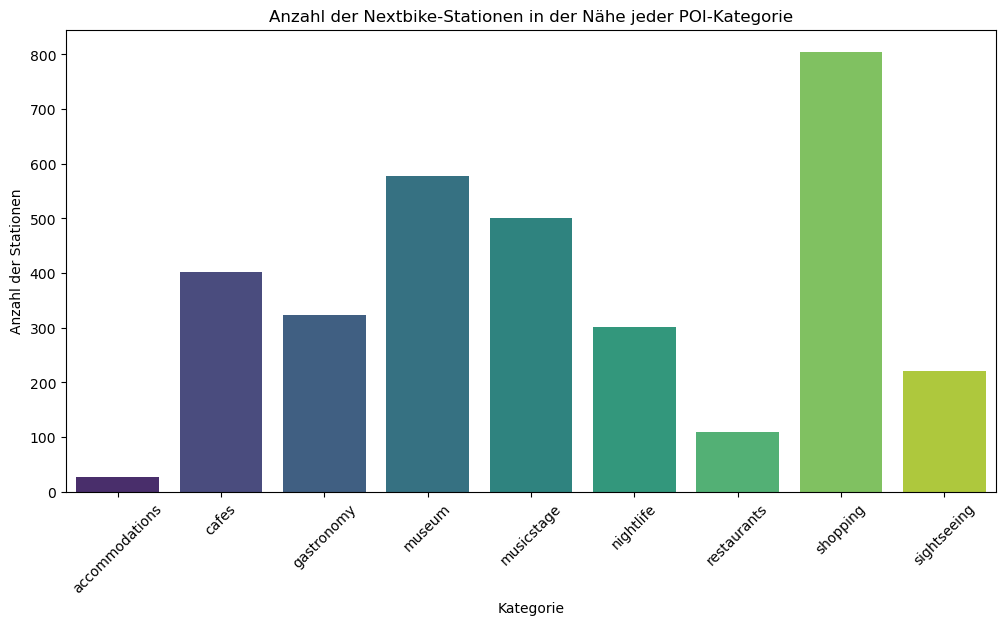

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisieren der Anzahl der Nextbike-Stationen in der Nähe jeder POI-Kategorie
plt.figure(figsize=(12, 6))
sns.barplot(data=category_station_counts, x='category', y='station_count', palette='viridis')
plt.title('Anzahl der Nextbike-Stationen in der Nähe jeder POI-Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl der Stationen')
plt.xticks(rotation=45)
plt.show()


# Set up Spark

In [ ]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import os
from pyspark.sql import SparkSession

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.2.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.0 pyspark-shell'

# Configure the Spark session to connect to the specified Spark master
spark = SparkSession.builder \
    .appName("KafkaSparkStream") \
    .master("spark://172.29.16.102:7077") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()
# Kafka-Parameter
kafka_bootstrap_servers = 'localhost:29093'  # Ändern Sie dies auf die Adresse Ihres Kafka-Servers
kafka_topic = 'nextbike_wien'

# Definieren des Schemas für die JSON-Daten
schema = StructType([
    StructField("station", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("available_bikes", IntegerType(), True)
])

# Daten von Kafka lesen
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
    .option("subscribe", kafka_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Konvertieren der binären Wertspalte in einen String
df = df.selectExpr("CAST(value AS STRING)")

# JSON-Daten analysieren und das Schema anwenden
df = df.withColumn("jsonData", from_json(col("value"), schema)).select("jsonData.*")

# Streaming-Daten in der Konsole anzeigen
query = df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

query.awaitTermination()

In [ ]:
spark.stop()

# Experiment: Wetterdaten & Bike Nutzung plotten

In [ ]:
from kafka import KafkaConsumer
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Kafka Consumer für Wetterdaten
weather_consumer = KafkaConsumer(
    'weather-data',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='weather-group',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Kafka Consumer für Nextbike-Daten
nextbike_consumer = KafkaConsumer(
    'nextbike_wien',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='nextbike-group',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# DataFrames zum Speichern der empfangenen Daten
weather_data = pd.DataFrame(columns=['Zeit', 'Temperatur'])
nextbike_data = pd.DataFrame(columns=['station', 'geo_latitude', 'geo_longitude', 'available_bikes'])

# Funktion zum Aktualisieren der Plots
def update_plots():
    global weather_data, nextbike_data
    
    plt.figure(figsize=(14, 7))

    # Plot für die Temperaturdaten
    plt.subplot(2, 1, 1)
    sns.lineplot(data=weather_data, x='Zeit', y='Temperatur')
    plt.title('Temperaturverlauf')
    plt.xlabel('Zeit')
    plt.ylabel('Temperatur (°C)')

    # Plot für die Nextbike-Nutzung
    plt.subplot(2, 1, 2)
    sns.lineplot(data=nextbike_data, x='Zeit', y='available_bikes')
    plt.title('Nextbike-Nutzung')
    plt.xlabel('Zeit')
    plt.ylabel('Verfügbare Fahrräder')

    plt.tight_layout()
    plt.show()

# Funktion zum Empfangen der Wetterdaten
def consume_weather_data():
    global weather_data
    for message in weather_consumer:
        data = message.value
        data['Zeit'] = datetime.strptime(data['Zeit'], '%H:%M')
        data['Temperatur'] = float(data['Temperatur'].replace('°C', '').strip())
        weather_data = weather_data.append(data, ignore_index=True)
        if len(weather_data) > 500:
            weather_data = weather_data[-500:]
        update_plots()

# Funktion zum Empfangen der Nextbike-Daten
def consume_nextbike_data():
    global nextbike_data
    for message in nextbike_consumer:
        data = message.value
        data['Zeit'] = datetime.now()
        nextbike_data = nextbike_data.append(data, ignore_index=True)
        if len(nextbike_data) > 500: 
            nextbike_data = nextbike_data[-500:]
        update_plots()

# Starten der Consumer in separaten Threads
from threading import Thread

weather_thread = Thread(target=consume_weather_data)
nextbike_thread = Thread(target=consume_nextbike_data)

weather_thread.start()
nextbike_thread.start()

weather_thread.join()
nextbike_thread.join()